In [1]:
import os
import glob
import gzip
import nibabel as nib
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [2]:
def extract_gz_file(gz_file, output_file):
    if not os.path.exists(output_file):
        with gzip.open(gz_file, 'rb') as f_in:
            with open(output_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

In [3]:
def find_global_min_max(files):
    global_min, global_max = np.inf, -np.inf
    for file in files:
        try:
            img = nib.load(file)
            data = img.get_fdata()
            file_min, file_max = data.min(), data.max()
            global_min, global_max = min(global_min, file_min), max(global_max, file_max)
        except Exception as e:
            print(f"Error processing file {file}: {e}")
    return global_min, global_max

In [4]:
def scale_and_save_image(input_file, output_dir, scaler, global_min, global_max):
    try:
        
        print(input_file)
        img = nib.load(input_file)
        data = img.get_fdata()

        print("Original data shape:", data.shape, "Type:", data.dtype)
        print("Original data statistics - Mean:", np.mean(data), "Std:", np.std(data))

        # Normalize data using global min and max
        data_normalized = (data - global_min) / (global_max - global_min)

        # Apply MinMaxScaler
        scaled_data = scaler.fit_transform(data_normalized.reshape(-1, 1)).reshape(data.shape)
        print("Scaled data statistics - Mean:", np.mean(scaled_data), "Std:", np.std(scaled_data))

        scaled_img = nib.Nifti1Image(scaled_data, affine=img.affine)
        scaled_file_name = os.path.join(output_dir, os.path.basename(input_file).replace('.nii', '_inst_scaled.nii.gz'))
        nib.save(scaled_img, scaled_file_name)
    except Exception as e:
        print(f"Error processing file {input_file}: {e}")

In [ ]:
root_dir = '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research'
institutions = ['Penn', 'CWRU', 'NYU', 'TJU', 'OSU', 'RH']

all_files = []
for inst in institutions:
    baseline_dir = os.path.join(root_dir, inst, 'Baseline')
    baseline_files = glob.glob(f"{baseline_dir}/*.nii.gz")
    all_files.extend(baseline_files)

# Extract and prepare all files
extracted_files = [file[:-3] for file in all_files]
for file in all_files:
    extract_gz_file(file, file[:-3])

# Find global min and max across the entire dataset
global_min, global_max = find_global_min_max(extracted_files)

# Directory for storing scaled images by institution
min_max_scaled_by_dataset_dir = '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/Scaled/Min_Max_Scaled/By_Dataset'

# Scale and save each image using the global min and max
for inst in institutions:
    min_max_inst_dir = os.path.join(min_max_scaled_by_dataset_dir, inst)
    os.makedirs(min_max_inst_dir, exist_ok=True)
    
    inst_files = glob.glob(os.path.join(root_dir, inst, 'Baseline/*.nii.gz'))
    extracted_inst_files = [file[:-3] for file in inst_files]

    for extracted_file in extracted_inst_files:
        scale_and_save_image(extracted_file, min_max_inst_dir, MinMaxScaler(), global_min, global_max)

In [6]:
unscaled_image = '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/Penn/Baseline/AAQZ_2013.10.25_adc_LPS_rSRI_SSFinal.nii'

unscaled_img= nib.load(unscaled_image)
unscaled_data = unscaled_img.get_fdata()

unique = np.unique(unscaled_data)
unique

array([0.00000000e+00, 1.81895246e-08, 5.39711095e-07, ...,
       1.11786956e-02, 1.13028623e-02, 1.13395546e-02])

In [11]:
scaled_image = '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/Scaled/Min_Max_Scaled/By_Dataset/Penn/AAQZ_2013.10.25_adc_LPS_rSRI_SSFinal_inst_scaled.nii'

scaled_img= nib.load(scaled_image)
scaled_data = scaled_img.get_fdata()

unique = np.unique(scaled_data)
unique

array([0.00000000e+00, 1.60407944e-06, 4.75954439e-05, ...,
       9.85814349e-01, 9.96764225e-01, 1.00000000e+00])

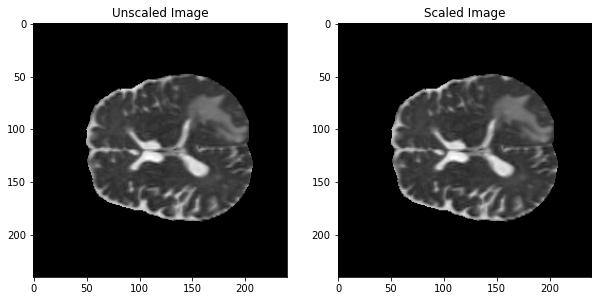

In [12]:
import matplotlib.pyplot as plt

# Assuming the images are 3D, we take a slice from the middle for display
slice_idx = unscaled_data.shape[2] // 2

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(unscaled_data[:, :, slice_idx], cmap='gray')
plt.title('Unscaled Image')
plt.subplot(1, 2, 2)
plt.imshow(scaled_data[:, :, slice_idx], cmap='gray')
plt.title('Scaled Image')
plt.show()

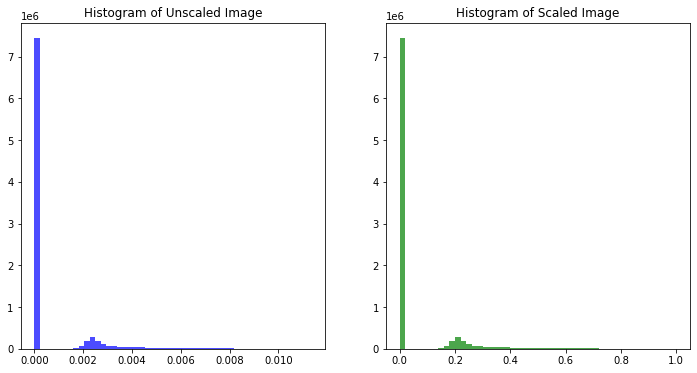

Unscaled Image - Mean: 0.0005641350278775397 Std: 0.001431940029537309
Scaled Image - Mean: 0.049749311115646525 Std: 0.1262783314421404


In [13]:
import numpy as np

# Histogram comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(unscaled_data.ravel(), bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Unscaled Image')
plt.subplot(1, 2, 2)
plt.hist(scaled_data.ravel(), bins=50, color='green', alpha=0.7)
plt.title('Histogram of Scaled Image')
plt.show()

# Basic statistics
print("Unscaled Image - Mean:", np.mean(unscaled_data), "Std:", np.std(unscaled_data))
print("Scaled Image - Mean:", np.mean(scaled_data), "Std:", np.std(scaled_data))


In [21]:
import os
import glob

def count_gz_files(directory):
    gz_files = glob.glob(f"{directory}/*.gz")  # Finds all .gz files in the directory
    return len(gz_files)

# Define your two directories
dir1 = '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/CWRU/Baseline'
dir2 = '/Users/yehudadicker/Library/Mobile Documents/com~apple~CloudDocs/Penn_Research/Scaled/Min_Max_Scaled/By_Dataset/CWRU'

# Count .gz files in each directory
gz_counts_dir1 = count_gz_files(dir1)
gz_counts_dir2 = count_gz_files(dir2)

print(gz_counts_dir1)
print(gz_counts_dir2)


120
120
